In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import math
import numpy as np
import torch
import pickle

from fastprogress import progress_bar
from functools import partial

from src.nanogpt.model import (
    GPT,
    GPTConfig
)

from src.nanogpt.vocab import Vocabulary

from src.vqvae.model import VQVAE

from src.environment.generic import SyntheticVideoDatasetConfig

from src.utils import compose

In [4]:
gpt: GPT = torch.load("./saved_models/4_2_24/gpt.pt")

with open("./saved_models/4_2_24/config.pkl", "rb") as handle:
    config: GPTConfig = pickle.load(handle)

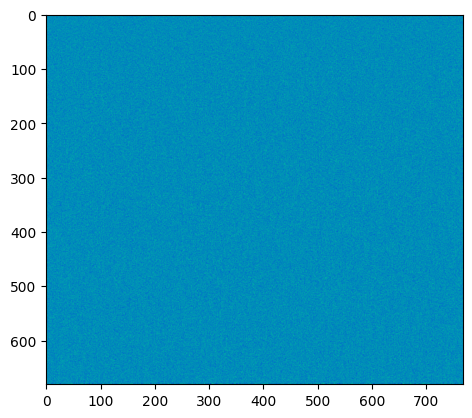

In [21]:
p = gpt.transformer['wpe'].weight.data
#p = torch.sigmoid(p * 10.0)
#p = torch.sort(p, dim=-2)[0]
plt.imshow(p, cmap="winter_r")

In [5]:
config

GPTConfig(block_size=681, vocab_size=1074, n_layer=12, n_head=12, n_embd=768, dropout=0.0, bias=False)

In [6]:
vocab = Vocabulary()

vocab.add_token("<sos>")
vocab.add_token("<eos>")
vocab.add_token_range("visual", 1024)
vocab.add_token_range("localization-x", 8)
vocab.add_token_range("localization-y", 8)
vocab.add_token_range("localization-pitch", 16)
vocab.add_token_range("localization-yaw", 16)

tokens_per_localization = 4
tokens_per_img = 64

num_frames = 10

In [7]:
device="cuda"
vqvae: VQVAE = torch.load("./saved_models/3_26_24/vqvae.pt")
vqvae.to(device)
gpt.to(device)

GPT(
  (transformer): ModuleDict(
    (wte): Embedding(1074, 768)
    (wpe): Embedding(681, 768)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-11): 12 x Block(
        (ln_1): LayerNorm()
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=768, out_features=2304, bias=False)
          (c_proj): Linear(in_features=768, out_features=768, bias=False)
          (attn_dropout): Dropout(p=0.0, inplace=False)
          (resid_dropout): Dropout(p=0.0, inplace=False)
        )
        (ln_2): LayerNorm()
        (mlp): MLP(
          (c_fc): Linear(in_features=768, out_features=3072, bias=False)
          (gelu): GELU(approximate='none')
          (c_proj): Linear(in_features=3072, out_features=768, bias=False)
          (dropout): Dropout(p=0.0, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm()
  )
  (lm_head): Linear(in_features=768, out_features=1074, bias=False)
)

In [8]:
# Preprocess dataset
train_x: torch.Tensor = compose(
    lambda x: x / 255.0,
    partial(torch.permute, dims=(0, 1, 4, 2, 3)),
    torch.Tensor.float,
    torch.from_numpy,
    np.load
)("./datasets/4_2_24/frames.npy")

train_y: np.ndarray = compose(
    #torch.Tensor.float,
    #torch.from_numpy,
    np.load
)("./datasets/4_2_24/matrices.npy")

with open("./datasets/4_2_24/config.pkl", "rb") as handle:
    dataset_config: SyntheticVideoDatasetConfig = pickle.load(handle)

In [9]:
# Produce to convert a position in space to a series of tokens
def localization_matrix_to_token_batch(ms: np.ndarray):
    spread: float = dataset_config.trajectory_factory.args[0].spread
    
    # Tokenize x/y position
    ps = ms[:, :2, -1] / spread * 0.5 + 0.5
    ps = ps.clip(0.0, 1.0)
    x = ps[:, 0]
    y = ps[:, 1]
    x = (x * vocab.get_range_len("localization-x")).astype(np.int32)
    y = (y * vocab.get_range_len("localization-y")).astype(np.int32)
    x = vocab.get_token_in_range("localization-x", x)
    y = vocab.get_token_in_range("localization-y", y)

    # Tokenize pitch/yaw
    forward_dir = ms[:, :3, 2]

    pitch = np.arcsin(forward_dir[:, 1])
    yaw = np.arctan2(forward_dir[:, 0], forward_dir[:, 2])

    assert np.all(-np.pi / 2 < yaw) and np.all(yaw < np.pi / 2), "Yaw is %s" % yaw
    assert np.all(-np.pi / 2 < pitch) and np.all(pitch < np.pi / 2), "Pitch is %s" % pitch

    # let's say +/- 90 degrees is the max
    ang_lim = np.deg2rad(90.0)
    pitch = pitch / ang_lim * 0.5 + 0.5
    yaw = yaw / ang_lim * 0.5 + 0.5
    pitch = (pitch * vocab.get_range_len("localization-pitch")).astype(np.int32)
    yaw = (yaw * vocab.get_range_len("localization-yaw")).astype(np.int32)
    pitch = vocab.get_token_in_range("localization-pitch", pitch)
    yaw = vocab.get_token_in_range("localization-yaw", yaw)

    return np.stack([x, y, pitch, yaw], axis=1)

localization_matrix_to_token_pipeline = compose(
    partial(torch.Tensor.to, device=device),
    torch.from_numpy,
    localization_matrix_to_token_batch
)

In [10]:
train_i = torch.from_numpy(np.load("./datasets/4_2_24/indices.npy"))

In [ ]:
torch.cuda.empty_cache()
with torch.no_grad():
    vqvae.to(device)

    # Construct prompt
    gen_slice = np.arange(10, 10+4)

    indices = train_i[gen_slice].to(device)
    start_token = torch.tensor([[ vocab.get_token("<sos>") ]], device=device).repeat(indices.size(0), 1)
    tokens = [start_token]
    for i in range(num_frames):
        tokens.append(localization_matrix_to_token_pipeline(train_y[gen_slice, i]))
        if i != num_frames - 1:
            tokens.append(vocab.get_token_in_range("visual", indices[:, i, :]))
    tokens = torch.cat(tokens, dim=1)

    # Generate new tokens
    generated = gpt.generate(tokens, tokens_per_img, temperature=0.9)
    generated = generated[:, -tokens_per_img:]
    generated = generated - vocab.get_range_start("visual")
    generated = torch.maximum(generated, torch.zeros_like(generated))
    generated = torch.minimum(generated, torch.ones_like(generated) * (vocab.get_range_len("visual") - 1))
    
    # Decode into pixels
    z_quantized = []
    for i in range(generated.size(0)):
        embeddings: torch.Tensor = vqvae.vq.e_i_ts[:, generated[i]]
        embeddings = embeddings.reshape(-1, 8, 8)
        z_quantized.append(embeddings)
    z_quantized = torch.stack(z_quantized)
    imgs: torch.Tensor = vqvae.decoder(z_quantized)
    
    # Format to wandb.Image
    imgs: np.ndarray = imgs.cpu().permute(0, 2, 3, 1).numpy()
    imgs = (imgs.clip(0.0, 1.0) * 255.0).astype(np.uint8)
    real_imgs: np.ndarray = train_x[gen_slice, -1].permute(0, 2, 3, 1).numpy()
    real_imgs = (real_imgs.clip(0.0, 1.0) * 255.0).astype(np.uint8)
    imgs = np.concatenate([imgs, real_imgs], axis=2)

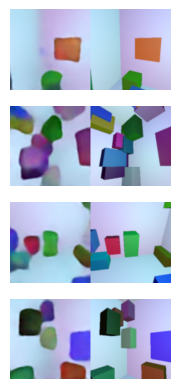

In [12]:
fig, ax = plt.subplots(nrows=imgs.shape[0])
for i in range(imgs.shape[0]):
    ax[i].axis('off')
    ax[i].imshow(imgs[i])

In [13]:
@torch.no_grad()
def render_localization_pairs(scene_idx: int, localization_pairs: list[tuple[int, int, int, int]]):
    vqvae.to(device)

    num_pairs = len(localization_pairs)

    # Construct prompt
    
    indices = train_i[scene_idx:scene_idx+1].to(device).repeat(num_pairs, 1, 1)
    start_token = torch.tensor([[ vocab.get_token("<sos>") ]], device=device).repeat(indices.size(0), 1)
    tokens = [start_token]
    for i in range(num_frames - 1):
        tokens.append(localization_matrix_to_token_pipeline(train_y[scene_idx:scene_idx+1, i]).repeat(num_pairs, 1))
        tokens.append(vocab.get_token_in_range("visual", indices[:, i, :]))
    
    # Now add localization
    localization_pairs = [
        (
            vocab.get_token_in_range("localization-x", item[0]),
            vocab.get_token_in_range("localization-y", item[1]),
            vocab.get_token_in_range("localization-pitch", item[2]),
            vocab.get_token_in_range("localization-yaw", item[3])
        ) for item in localization_pairs
    ]
    tokens.append(torch.tensor(localization_pairs, device=device))
    
    tokens = torch.cat(tokens, dim=1)

    # Generate new tokens
    generated = gpt.generate(tokens, tokens_per_img, temperature=0.9)
    generated = generated[:, -tokens_per_img:]
    generated = generated - vocab.get_range_start("visual")
    generated = torch.maximum(generated, torch.zeros_like(generated))
    generated = torch.minimum(generated, torch.ones_like(generated) * (vocab.get_range_len("visual") - 1))
    
    # Decode into pixels
    z_quantized = []
    for i in range(generated.size(0)):
        embeddings: torch.Tensor = vqvae.vq.e_i_ts[:, generated[i]]
        embeddings = embeddings.reshape(-1, 8, 8)
        z_quantized.append(embeddings)
    z_quantized = torch.stack(z_quantized)
    imgs: torch.Tensor = vqvae.decoder(z_quantized)
    
    # Format to wandb.Image
    imgs: np.ndarray = imgs.cpu().permute(0, 2, 3, 1).numpy()
    imgs = (imgs.clip(0.0, 1.0) * 255.0).astype(np.uint8)
    return imgs

In [14]:
train_y[0:1, 0].shape

(1, 4, 4)

In [15]:
localization_pairs = [(3, x, 3, 6) for x in range(2, 6)]
imgs = render_localization_pairs(2, localization_pairs)

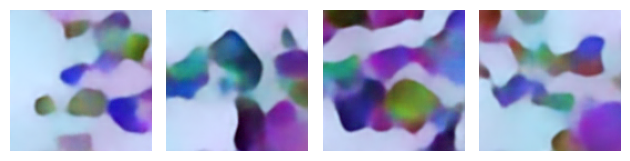

In [16]:
fig, ax = plt.subplots(ncols=4)
fig.set_tight_layout(True)
for j in range(4):
    ax[j].axis('off')
    ax[j].imshow(imgs[j])